In [2]:
# Associated rule based FP Growth Algo

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [5]:
# Read input file and extract data which will be accounted for FP growth


cust_data = pd.read_csv("Policy_Output_ptb.csv")

sub_cust_data = cust_data[["CustID","product_id","is_purchase"]]

# taking data which has is_purchase field enabled.
sub_cust_data = sub_cust_data[sub_cust_data.is_purchase == 1]



# Select and create set of policies and corresponding products name.
cust_policy = sub_cust_data.groupby('CustID')['product_id'].apply(list).reset_index(name='Prod_list') 

# another way working
#cust_policy = sub_cust_data.groupby('CustID').agg({'product_id':lambda x: list(x)})


policy_items = set()

for line in cust_policy["Prod_list"] :
        policy_items.update(line)

print(policy_items)    





{'p_24', 'p_9', 'p_0', 'p_5', 'p_16', 'p_19', 'p_27', 'p_8', 'p_17', 'p_4', 'p_20', 'p_25', 'p_31', 'p_3', 'p_1', 'p_15', 'p_30', 'p_22', 'p_11', 'p_33', 'p_32', 'p_18', 'p_21', 'p_10', 'p_23', 'p_26', 'p_14', 'p_12', 'p_13', 'p_6', 'p_2', 'p_29', 'p_7', 'p_28'}


In [6]:
# check shape and details of list containing policies and are purchased
output_list = list()        
for line in cust_policy["Prod_list"] :
    row_val = {item:0 for item in policy_items}
    row_val.update({item:1 for item in line})
    output_list.append(row_val)



policy_df = pd.DataFrame(output_list)    
policy_df.shape


#print(policy_df)

(2716, 34)

In [7]:
# Top 10 items that occur in the dataset and how much of the total sales they account for. We can
# plot a simple histogram that will help us extract this information.

total_policy_count = sum(policy_df.sum())

print(total_policy_count)

policy_summary_df = policy_df.sum().sort_values(ascending = False).reset_index().head(n=20)
policy_summary_df.rename(columns={policy_summary_df.columns[0]:'policy_name',policy_summary_df.columns[1]:'policy_count'}, inplace=True)
policy_summary_df.head()



31292


,policy_name,policy_count
0,p_17,2291
1,p_33,2118
2,p_32,2089
3,p_30,2085
4,p_31,2084


Text(0.5, 1.0, 'policy sales distribution')

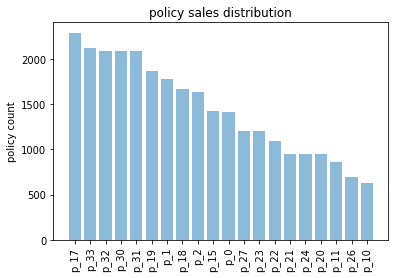

In [5]:
# create a summary dataframe using the previous code. use this dataframe to plot the top 20 most sold policies.
# here it will indicate which are popular policies.

# The bar graph depicting the policy purchased is depicted below. 
# share of total policies is claimed by only these 20 policies.

objects = (list(policy_summary_df['policy_name'].head(n=20)))
y_pos = np.arange(len(objects))
performance = list(policy_summary_df['policy_count'].head(n=20))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('policy count')
plt.title('policy sales distribution')




In [8]:
# Now find out how much percentage of total purchase is explained by these 20 polices alone. 
# Here the cumulative sum (the total sum of data as it grows with time) function offered by pandas (cumsum) is being used to 
# find this out. 
# Two columns have created dataframe. One will tell how much percentage of total purchases can be attributed to 
# a particular policy and the other will keep a cumulative sum of this sales percentage.

policy_summary_df['policy_perc'] = policy_summary_df['policy_count']/total_policy_count
policy_summary_df['total_perc'] = policy_summary_df.policy_perc.cumsum()
policy_summary_df.head(10)



,policy_name,policy_count,policy_perc,total_perc
0,p_17,2291,0.073214,0.073214
1,p_33,2118,0.067685,0.140899
2,p_32,2089,0.066758,0.207657
3,p_30,2085,0.066630,0.274287
4,p_31,2084,0.066598,0.340886
5,p_19,1867,0.059664,0.400550
6,p_1,1774,0.056692,0.457241
7,p_18,1670,0.053368,0.510610
8,p_2,1631,0.052122,0.562732
9,p_15,1424,0.045507,0.608239


In [9]:
# This shows us that the how much purchase is there by top five policies of the entire sales and only the top 20
# policies are responsible for over 50% of the sales! 
# This is important, as we don’t want to find association rules for items which are bought very infrequently.

policy_summary_df[policy_summary_df.total_perc <= 0.5].shape



(7, 4)

In [10]:
policy_summary_df[policy_summary_df.total_perc <= 0.5]

,policy_name,policy_count,policy_perc,total_perc
0,p_17,2291,0.073214,0.073214
1,p_33,2118,0.067685,0.140899
2,p_32,2089,0.066758,0.207657
3,p_30,2085,0.066630,0.274287
4,p_31,2084,0.066598,0.340886
5,p_19,1867,0.059664,0.400550
6,p_1,1774,0.056692,0.457241


In [11]:
# Creating Mining Rules
# Using the Orange and the Orange3-Associate frameworks, The orange3-associate
# package contains the implementation of FP growth. 

# convert our pandas dataframes to the Orange Table data structure.


# Orange Table Data Structure
# The Table data structure is the primary way to represent any tabular data in Orange. Although it is similar
# in some way to a numpy array or a pandas dataframe, it differs from them in the way it stores metadata
# about the actual data. In this case pandas dataframe can be converted into the Table data structure
# by providing the metadata about our columns. Need to define the domain for each of our variables. The
# domain means the possible set of values that each of our variables can use. This information will be stored
# as metadata and will be used in later transformation of the data. As our columns are only having binary
# values—i.e. either 0 or 1—we can easily create the domain by using this information. The following code
# snippet helps us convert our dataframe to an Orange table.

# Here we defined the domain of our data by specifying each variable as a DiscreteVariable having
# values as (0, 1). Then using this domain, we created our Table structure for our data.

input_assoc_rules = policy_df
domain_policy = Domain([DiscreteVariable.make(name=policy, values=['0', '1']) for policy in input_assoc_rules.columns])
data_pol_1 = Orange.data.Table.from_numpy(domain=domain_policy, X=input_assoc_rules.values,Y= None)




In [12]:
# Using the FP Growth Algorithm
# Now we have all the pieces required to perform our rule-mining. But before proceeding, we want to take care of one 
# more important aspect of the analysis. We saw in the earlier section how only a handful of items are responsible for 
# bulk of our sales so we want to prune our dataset to reflect this information. For this we have created a function 
# prune_dataset , which will help us reduce the size of our dataset based on our requirements. 
# The function can be used for performing two types of pruning (removing redundent cloumns which are not impacting on analysis)


def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, start_item = None, end_item = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',item_count.columns[1]:'item_count'}, inplace=True)
    if not start_item and not end_item: 
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]


In [13]:
# So we find out that we have only 5 policies responsible for 40% of sales and 2095 transactions that have
# those items along with other items and we can also see what those items are. 

output_df, item_counts = prune_dataset(input_df=policy_df, length_trans=2,total_sales_perc=0.4)
print(output_df.shape)
print(list(output_df.columns))



(2095, 5)
['p_17', 'p_33', 'p_32', 'p_30', 'p_31']


In [14]:
# The next step is to convert this selected data into the required model.
# The new addition to the previous code is the last line. This is required for coding our input so that the
# entire domain is represented as binary variables. This will complete all the parsing and data manipulation
# required for our rule-mining.

input_assoc_rules = output_df
domain_policy = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in input_assoc_rules.columns])
data_pol_1 = Orange.data.Table.from_numpy(domain=domain_policy,  X=input_assoc_rules.values,Y= None)
data_pol_1_en, mapping = OneHot.encode(data_pol_1, include_class=False)



In [16]:
# The final step is creating our rules. We need to specify two pieces of information for generating our
# rules: support and confidence. 
# An important piece of information is to start with a higher support, as lower support
# will mean a higher number of frequent policysets and hence a longer execution time. 
# We will specify a minsupport of 0.01—45 transactions at least—and see the number of frequent policysets that we get before we
# specify confidence and generate our rules.


min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*min_support))
num_trans = input_assoc_rules.shape[0]*min_support
policysets = dict(frequent_itemsets(data_pol_1_en, min_support=min_support))

print("lenght of policysets = ",len(policysets))



num of required transactions =  20
lenght of policysets =  31


In [19]:
# The next step is specifying a confidence value and generating our rules. We have written a code snippet that 
# will take a confidence value and generate the rules that fulfill our specified support and confidence criteria. 
# The rules generated are then decoded using the mapping and variable names. Orange3-Associate also provides a helper 
# function that will help us extract metrics about each of these rules. The following code snippet will perform rule 
# generation and decoding of rules, and then compile it all in a neat dataframe that we can use for further analysis.

confidence = 0.3
rules_df = pd.DataFrame()

if len(policysets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(policysets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_pol_1, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, policysets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")


Raw rules data frame of 55 rules generated


In [20]:
# The output of above functionality consists of the association rules dataframe that we can use for our
# analysis. policy number, consequent, antecedent, support, and confidence
# values can be altered or add / delete to generate different rules. 
# Here, we have collected rules having maximum lift for each of the items that can be a consequent (that
# appear on the right side) by using the following code.


# Sorting rules in our Policy Dataset

(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False))



,consequent,antecedent,support,confidence,lift
1,p_30,"p_33, p_32",2084,1.000000,1.005278
2,p_31,"p_33, p_32, p_30",2084,1.000000,1.005278
3,p_32,"p_33, p_30",2084,1.000000,1.002872
0,p_17,"p_33, p_32, p_30",2080,0.998081,1.002387
4,p_33,"p_32, p_30",2084,1.000000,1.000000
